In [1]:
import numpy as np
import nengo
import sys
import matplotlib.pyplot as plt
import h5py

In [2]:
with h5py.File("../../../data/pendulum_dataset.h5", "r") as f:
    ts = f["ts"][()]
    taus = f["taus"][()]
    thetas = f["phis"][()]

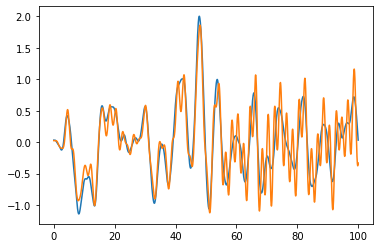

In [3]:
fig, ax = plt.subplots()
taus_norm = (taus - np.mean(taus)) / np.std(taus)
thetas_norm = (thetas - np.mean(thetas)) / np.std(thetas)
taus_norm /= np.percentile(np.abs(taus_norm), 95)
thetas_norm /= np.percentile(np.abs(thetas_norm), 95)
ax.plot(ts, taus_norm)
ax.plot(ts, thetas_norm)
#ax.set_xlim(200, 300)

dt = 1e-3

In [4]:
with h5py.File("../../../data/manual/chapters/04_temporal_tuning/ae3bf70a32be60b6_spatio_temporal_network_matrices.h5", "r") as f:
    W_rec = f["W_rec"][()]
    W_in = f["W_in"][()]
    gains = f["gains"][()]
    biases = f["biases"][()]

In [16]:
def execute_network(taus, thetas, W_in, W_rec, gains, biases, delay=0.75, dt=1e-3, tau=100e-3, tau_learn=20e-3):
    N_delay = int(delay / dt + 1e-9)
    print(N_delay)
    N = len(taus) - N_delay - 1
    n_neurons = len(gains)
    t_learn_off = 0.9 * N * dt

    with nengo.Network() as model:
        nd_in = nengo.Node(lambda t: [
            taus[(int(t / dt) + N_delay) % N],
            thetas[(int(t / dt)) % N],
        ])
        nd_tar = nengo.Node(lambda t: [
            thetas[(int(t / dt) + N_delay) % N],
        ])

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=1,
                               bias=biases,
                               gain=gains,
                               encoders=np.ones((n_neurons, 1)))

        nengo.Connection(nd_in,
                         ens_x.neurons,
                         transform=W_in[:, :, 0],
                         synapse=tau)

        nengo.Connection(ens_x.neurons,
                         ens_x.neurons,
                         transform=W_rec[:, :, 0],
                         synapse=tau)

        nd_out = nengo.Node(size_in=1)
        conn = nengo.Connection(
            ens_x.neurons,
            nd_out,
            transform=np.zeros((1, n_neurons)),
            synapse=tau_learn,
            learning_rule_type=nengo.PES(learning_rate=1e-4))

        nd_err = nengo.Node(size_in=1)
        nd_err_valve = nengo.Node(lambda t, x: x * (t < t_learn_off), size_in=1)
        nengo.Connection(nd_out, nd_err, synapse=None)
        nengo.Connection(nd_tar, nd_err, transform=-1, synapse=tau_learn)
        nengo.Connection(nd_tar, nd_err_valve, synapse=None)
        nengo.Connection(nd_err_valve, conn.learning_rule, synapse=None)


        p_in = nengo.Probe(nd_in, synapse=None)
        p_tar = nengo.Probe(nd_tar, synapse=None)
        p_out = nengo.Probe(nd_out, synapse=None)
        p_err = nengo.Probe(nd_err, synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(N * dt)

    return sim.trange(), sim.data[p_in], sim.data[p_tar], sim.data[p_out], sim.data[p_err]

In [17]:
T0 = int(10.0 / dt)
ts, xs_in, xs_tar, xs_out, xs_err = execute_network(taus_norm[T0:], thetas_norm[T0:], W_in=W_in, W_rec=W_rec, gains=gains, biases=biases)

900


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

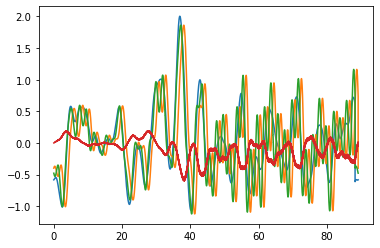

In [19]:
fig, ax = plt.subplots()
ax.plot(ts, xs_in)
ax.plot(ts, xs_tar)
ax.plot(ts, xs_out)
#ax.set_xlim(80, 85)

In [44]:
def learning_error(xs_tar, xs_out, bin_width=50.0, dt=1e-3):
    N_bin = int(bin_width / dt + 1e-9)
    N_bins = int(xs_tar.shape[0] / N_bin)
    N_smpls = N_bin * N_bins
    print(N_bin, N_bins)
    bins_tar = xs_tar[:N_smpls].reshape(N_bins, N_bin)
    bins_out = xs_out[:N_smpls].reshape(N_bins, N_bin)
    rmss = np.sqrt(np.mean(np.square(bins_tar), axis=1))
    #rms = np.sqrt(np.mean(np.square(xs_tar)))
    rmses = np.sqrt(np.mean(np.square(bins_tar - bins_out), axis=1))
    return rmses / rmss

In [45]:
errs_with_tau = learning_error(xs_tar, xs_out)

50000 19


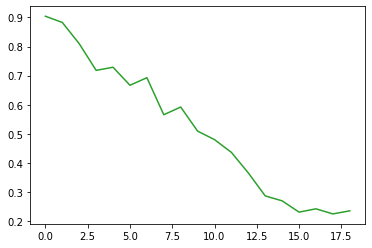

In [46]:
fig, ax = plt.subplots()
#ax.plot(errs_no_tau, 'tab:green')
ax.plot(errs_with_tau, 'tab:green')